In [1]:
# Modules
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import inspect
import warnings
import pygam

from pandas import DataFrame
from sklearn import ensemble, metrics, model_selection, preprocessing, tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import PartialDependenceDisplay

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
def display_roc(fp_rates:np.ndarray, tp_rates:np.ndarray, thresholds:np.ndarray, best_index:int=None) -> None:
    '''Displays ROC curve and AUC'''
    auc     = metrics.auc(fp_rates, tp_rates)
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(fp_rates, tp_rates, color='blue', label=f'AUC: {auc:0.4f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='dashed')
    if best_index is not None:
        ax.scatter(fp_rates[best_index], tp_rates[best_index], marker='o', c='lightgreen', s=7.5**2, edgecolor='black', zorder=2, label=f'Threshold: {thresholds[best_index]:0.4f}')
    ax.set_title('Receiver operating characteristic')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc='lower right', frameon=False)
    pyplot.tight_layout()
    pyplot.show()

def display_history(history:dict, stat:str='loss', validation:bool=False) -> None:
    '''Displays training history for a statistic'''
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(history[stat], label='Training sample')
    if validation:
        ax.plot(history[f'val_{stat}'], label='Validation sample')
    ax.set_title(f'Model training', fontsize=15)
    ax.set_ylabel(stat.title())
    ax.set_xlabel('Epoch')
    ax.legend(frameon=False)
    pyplot.tight_layout()
    pyplot.show()
    
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

## Logistic Regression

In [5]:
# Import the data
df_selected = pd.read_csv('Data_selection.csv')

##### 1.1 Initial Fitting on data set with preliminary feature selection

In [6]:
df = df_selected

# Randomly split the data set into training and testing and deal with the imbalanced dependent variable using SMOTE
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size = 0.75, shuffle = True, random_state = 480)

undersampler = RandomUnderSampler(random_state=480)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

# Create a logistic regression classifier object
logreg = LogisticRegression()

# Use Recursive Feature Elimination (RFE) for stepwise variable selection
rfe = RFE(logreg)
rfe.fit(X_train_resampled, y_train_resampled)

# Fit the model using the selected features
selected_features = X_train_resampled.columns[rfe.support_]
logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[selected_features]))
result = logit_model.fit()

# Iteratively check VIF and remove variables with high VIF values
max_vif = np.inf

while max_vif > 10:
    # Calculate VIF for the selected independent variables
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X_train_resampled[selected_features].values, i) for i in range(X_train_resampled[selected_features].shape[1])]
    vif['features'] = selected_features

    # Remove variables with high VIF values
    high_vif_features = vif[vif['VIF Factor'] > 10]['features']
    selected_features = selected_features.drop(high_vif_features)

    # Refit the logistic regression model using the remaining independent variables
    logreg.fit(X_train_resampled[selected_features], y_train_resampled)

    # Update max_vif
    max_vif = vif['VIF Factor'].max()
    
# Calculate and display the final VIF values for the remaining independent variables
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train_resampled[selected_features].values, i) for i in range(X_train_resampled[selected_features].shape[1])]
vif['features'] = selected_features
print(vif)

logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[selected_features]))
result = logit_model.fit()

# Iteratively remove variables with high p-values and refit the model
max_pvalue = np.inf
while max_pvalue >= 0.05:
    # Remove variables with high p-values
    high_pvalue_features = result.pvalues[result.pvalues >= 0.05].index
    selected_features = selected_features.drop(high_pvalue_features)

    # Refit the logistic regression model using the remaining independent variables
    logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[selected_features]))
    result = logit_model.fit()

    # Update max_pvalue
    max_pvalue = result.pvalues.max()

# Display the final regression results
print(result.summary())

         Current function value: 0.618513
         Iterations: 35
    VIF Factor                                           features
0     1.000920    application_train_flag_OBS_30_CNT_SOCIAL_CIRCLE
1     1.159117                             REGION_RATING_CLIENT_1
2     1.163836                                   FLAG_CONT_MOBILE
3     1.798114            AMT_CREDIT_SUM_LIMIT_(20.16, 23563.475]
4     1.168885              AMT_RECIVABLE_(62175.128, 913096.639]
5     1.060500                             REG_CITY_NOT_LIVE_CITY
6     1.357453                         REG_REGION_NOT_LIVE_REGION
7     2.164443            AMT_CREDIT_SUM_DEBT_(-6981558.211, 0.0]
8     2.592393                         NAME_FAMILY_STATUS_Married
9     3.631273           AMT_CREDIT_MAX_OVERDUE_(-0.001, 861.375]
10    5.146431                                         DAYS_BIRTH
11    2.729424                                    AMT_GOODS_PRICE
12    1.390955                  AMT_CREDIT_SUM_(-0.001, 142204.5]
13    3.45

In [9]:
# Make predictions on the training and test sets
y_pred_train = result.predict(sm.add_constant(X_train_resampled[selected_features]))
y_pred_test = result.predict(sm.add_constant(X_test[selected_features]))

# Compute in-sample performance metrics
accuracy_train = accuracy_score(y_train_resampled, y_pred_train.round())
precision_train = precision_score(y_train_resampled, y_pred_train.round())
recall_train = recall_score(y_train_resampled, y_pred_train.round())
#f1_score_train = f1_score(y_train_resampled, y_pred_train.round())
roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train.round())

# Compute out-of-sample performance metrics
accuracy_test = accuracy_score(y_test, y_pred_test.round())
precision_test = precision_score(y_test, y_pred_test.round())
recall_test = recall_score(y_test, y_pred_test.round())
#f1_score_test = f1_score(y_test, y_pred_test.round())
roc_auc_test = roc_auc_score(y_train_resampled, y_pred_train.round())

# assuming you have already computed the performance metrics
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC AUC'],
        'Training': [accuracy_train, precision_train, recall_train, roc_auc_train],
        'Test': [accuracy_test, precision_test, recall_test, roc_auc_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,Accuracy,0.649769,0.664325
1,Precision,0.654178,0.140481
2,Recall,0.635469,0.614816
3,ROC AUC,0.649769,0.649769


In [10]:
rmse_train = mean_squared_error(y_train_resampled, y_pred_train, squared = False)
mae_train = mean_absolute_error(y_train_resampled, y_pred_train)

rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
mae_test = mean_absolute_error(y_test, y_pred_test)

data = {'Metric': ['RMSE', 'MAE'],
        'Training': [rmse_train, mae_train],
        'Test': [rmse_test, mae_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,RMSE,0.466752,0.465233
1,MAE,0.435807,0.435348


##### 1.2 Hyperparameter Tuning using Cross-validation on data set with preliminary feature selection

In [ ]:
# Define the hyperparameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 200, 300]}

# Create a logistic regression classifier object
logreg = LogisticRegression()

# Perform hyperparameter tuning using cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train_resampled[selected_features], y_train_resampled)

# Display the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

##### 1.3 Refit the model using optimal parameters found through hyperparameter tuning on data set with preliminary feature selection

In [11]:
# Create a logistic regression classifier object with the best hyperparameters
logreg = LogisticRegression(C=0.1, max_iter=300, penalty='l2', solver='sag')

# Use Recursive Feature Elimination (RFE) for stepwise variable selection
rfe = RFE(logreg)
rfe.fit(X_train_resampled, y_train_resampled)

# Fit the model using the selected features
selected_features = X_train_resampled.columns[rfe.support_]
logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[selected_features]))
result = logit_model.fit()

# Iteratively check VIF and remove variables with high VIF values
max_vif = np.inf

while max_vif > 10:
    # Calculate VIF for the selected independent variables
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X_train_resampled[selected_features].values, i) for i in range(X_train_resampled[selected_features].shape[1])]
    vif['features'] = selected_features

    # Remove variables with high VIF values
    high_vif_features = vif[vif['VIF Factor'] > 10]['features']
    selected_features = selected_features.drop(high_vif_features)

    # Refit the logistic regression model using the remaining independent variables
    logreg.fit(X_train_resampled[selected_features], y_train_resampled)

    # Update max_vif
    max_vif = vif['VIF Factor'].max()
    
# Calculate and display the final VIF values for the remaining independent variables
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train_resampled[selected_features].values, i) for i in range(X_train_resampled[selected_features].shape[1])]
vif['features'] = selected_features
print(vif)

logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[selected_features]))
result = logit_model.fit()

# Iteratively remove variables with high p-values and refit the model
max_pvalue = np.inf
while max_pvalue >= 0.05:
    # Remove variables with high p-values
    high_pvalue_features = result.pvalues[result.pvalues >= 0.05].index
    selected_features = selected_features.drop(high_pvalue_features)

    # Refit the logistic regression model using the remaining independent variables
    logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled[selected_features]))
    result = logit_model.fit()

    # Update max_pvalue
    max_pvalue = result.pvalues.max()

# Display the final regression results
print(result.summary())

         Current function value: 0.618531
         Iterations: 35
    VIF Factor                                           features
0     1.157961                             REGION_RATING_CLIENT_1
1     1.161661                                   FLAG_CONT_MOBILE
2     1.730119            AMT_CREDIT_SUM_LIMIT_(20.16, 23563.475]
3     1.167670              AMT_RECIVABLE_(62175.128, 913096.639]
4     1.058114                             REG_CITY_NOT_LIVE_CITY
5     1.357005                         REG_REGION_NOT_LIVE_REGION
6     2.147909            AMT_CREDIT_SUM_DEBT_(-6981558.211, 0.0]
7     2.590625                         NAME_FAMILY_STATUS_Married
8     3.498884           AMT_CREDIT_MAX_OVERDUE_(-0.001, 861.375]
9     5.053827                                         DAYS_BIRTH
10    2.718971                                    AMT_GOODS_PRICE
11    1.390321                  AMT_CREDIT_SUM_(-0.001, 142204.5]
12    3.244990  NAME_EDUCATION_TYPE_Secondary / secondary special
13    1.21

In [13]:
# Make predictions on the training and test sets
y_pred_train = result.predict(sm.add_constant(X_train_resampled[selected_features]))
y_pred_test = result.predict(sm.add_constant(X_test[selected_features]))

# Compute in-sample performance metrics
accuracy_train = accuracy_score(y_train_resampled, y_pred_train.round())
precision_train = precision_score(y_train_resampled, y_pred_train.round())
recall_train = recall_score(y_train_resampled, y_pred_train.round())
#f1_score_train = f1_score(y_train_resampled, y_pred_train.round())
roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train.round())

# Compute out-of-sample performance metrics
accuracy_train = accuracy_score(y_test, y_pred_test.round())
precision_train = precision_score(y_test, y_pred_test.round())
recall_train = recall_score(y_test, y_pred_test.round())
#f1_score_train = f1_score(y_test, y_pred_test.round())
roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train.round())

# assuming you have already computed the performance metrics
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC AUC'],
        'Training': [accuracy_train, precision_train, recall_train, roc_auc_train],
        'Test': [accuracy_test, precision_test, recall_test, roc_auc_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,Accuracy,0.663922,0.664325
1,Precision,0.140400,0.140481
2,Recall,0.615298,0.614816
3,ROC AUC,0.649419,0.649769


In [14]:
rmse_train = mean_squared_error(y_train_resampled, y_pred_train, squared = False)
mae_train = mean_absolute_error(y_train_resampled, y_pred_train)

rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
mae_test = mean_absolute_error(y_test, y_pred_test)

data = {'Metric': ['RMSE', 'MAE'],
        'Training': [rmse_train, mae_train],
        'Test': [rmse_test, mae_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,RMSE,0.466890,0.465350
1,MAE,0.436064,0.435598


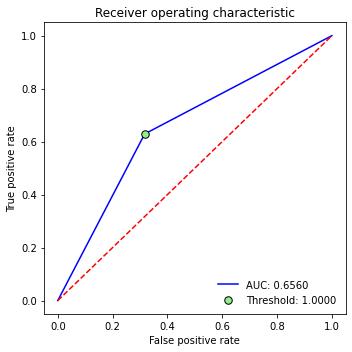

In [16]:
# ROC curve
yh_test = np.squeeze(rfe.predict(X_test_resampled))
fp_rates, tp_rates, thresholds = metrics.roc_curve(y_test_resampled, yh_test)
youden = np.argmax(tp_rates - fp_rates)
display_roc(fp_rates, tp_rates, thresholds, youden)

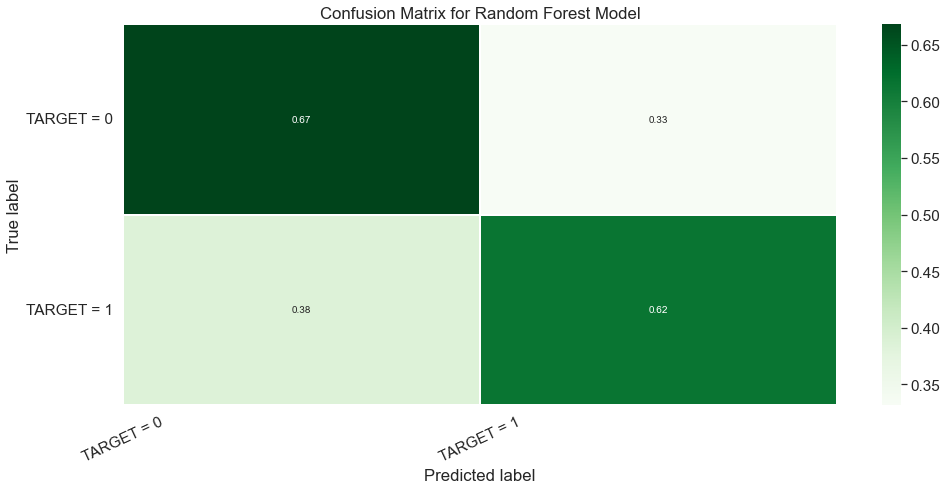

In [17]:
# Get and reshape confusion matrix data
threshold = 0.5
y_pred_test = np.where(y_pred_test > threshold, 1, 0)

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
pyplot.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=pyplot.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['TARGET = 0', 'TARGET = 1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
pyplot.xticks(tick_marks, class_names, rotation=25)
pyplot.yticks(tick_marks2, class_names, rotation=0)
pyplot.xlabel('Predicted label')
pyplot.ylabel('True label')
pyplot.title('Confusion Matrix for Random Forest Model')
pyplot.show()

In [18]:
def check_linearity(df, target, features):
    """
    Check linearity between independent variables and the log odds assumption.
    
    :param df: DataFrame containing the data
    :param target: Name of the target variable
    :param features: List of feature names
    :return: DataFrame containing the p-values for each feature
    """
    y = df[target]
    p_values = []
    for feature in features:
        x = df[feature]
        x = sm.add_constant(x)
        model = sm.Logit(y, x)
        result = model.fit()
        p_values.append(result.pvalues[1])
    
    results_df = pd.DataFrame({'Feature': features, 'p-value': p_values})
    return results_df

results_df = check_linearity(df_selected, 'TARGET', selected_features)
results_df

Optimization terminated successfully.
         Current function value: 0.279597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.279399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.280210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.279424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.277434
  

,Feature,p-value
0,REGION_RATING_CLIENT_1,2.174505e-110
1,FLAG_CONT_MOBILE,0.000000e+00
2,"AMT_CREDIT_SUM_LIMIT_(20.16, 23563.475]",9.024220e-206
3,"AMT_RECIVABLE_(62175.128, 913096.639]",4.421925e-171
4,REG_CITY_NOT_LIVE_CITY,3.954239e-49
5,REG_REGION_NOT_LIVE_REGION,0.000000e+00
6,"AMT_CREDIT_SUM_DEBT_(-6981558.211, 0.0]",4.010072e-177
7,NAME_FAMILY_STATUS_Married,9.473296e-44
8,"AMT_CREDIT_MAX_OVERDUE_(-0.001, 861.375]",2.134252e-156
9,DAYS_BIRTH,0.000000e+00


In [19]:
# Calculate the Wald statistics for each variable
wald_statistics = result.params / result.bse
wald_statistics = wald_statistics ** 2

# Get the top 10 variables with the highest Wald statistics
top_10_variables = wald_statistics.nlargest(10)

# Display the results
top_10_variables

FLAG_CONT_MOBILE                                     1730.774518
DAYS_BIRTH                                            329.119581
NAME_EDUCATION_TYPE_Secondary / secondary special     184.667409
const                                                 182.577697
REG_REGION_NOT_LIVE_REGION                            179.098177
AMT_RECIVABLE_(62175.128, 913096.639]                 175.029827
REG_CITY_NOT_LIVE_CITY                                124.878449
AMT_CREDIT_MAX_OVERDUE_(-0.001, 861.375]              102.179347
DAYS_EMPLOYED_(-458.0, -144.0]                         86.695818
DAYS_EMPLOYED_(-822.0, -458.0]                         77.900182
dtype: float64

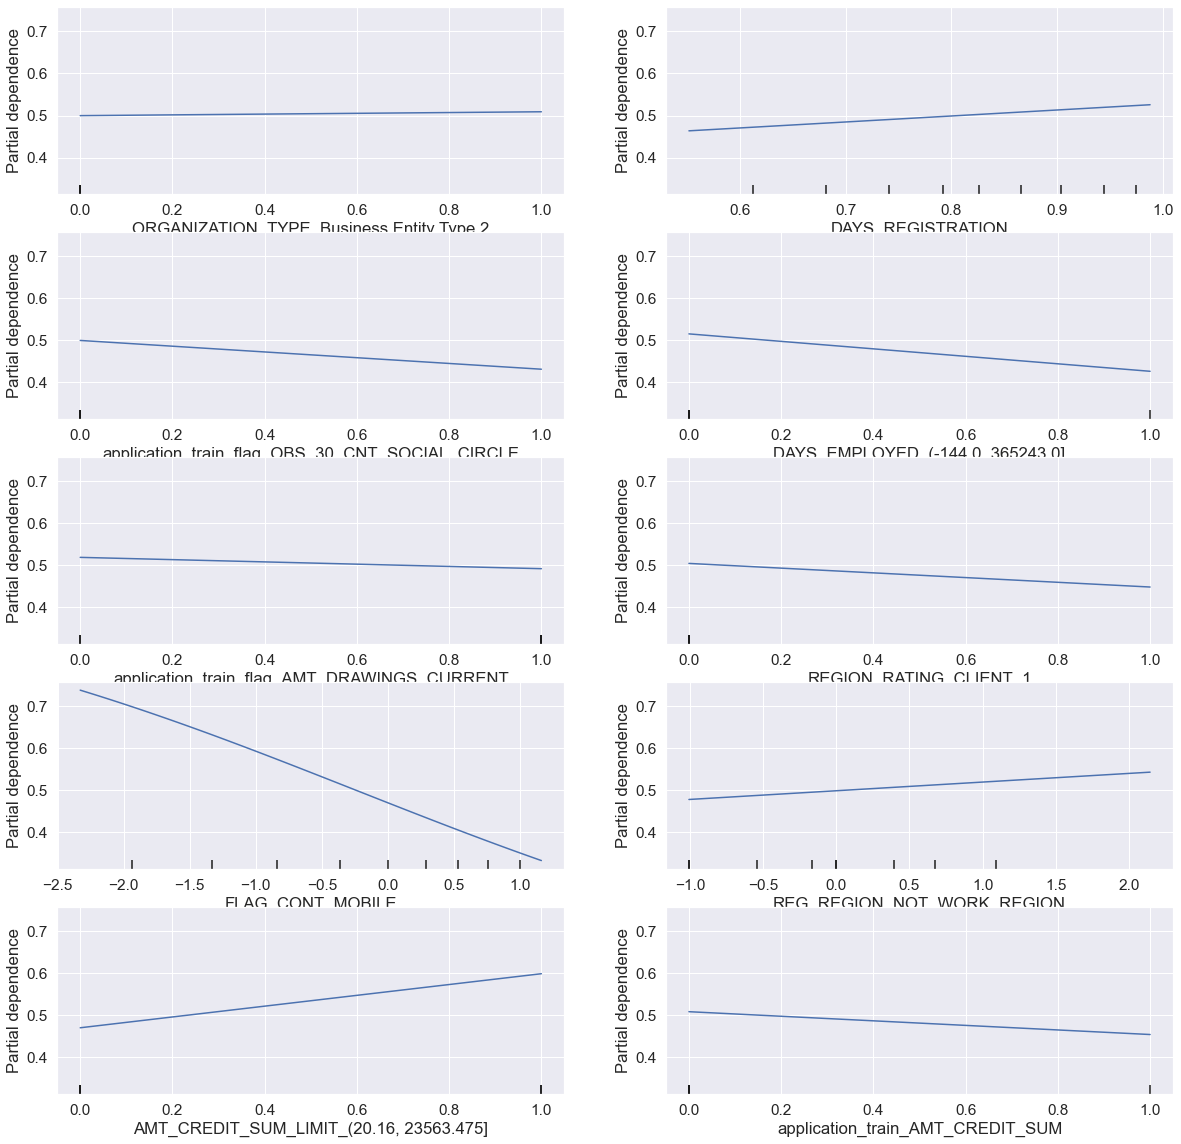

In [23]:
# Get the indices of top 10 features
indices = np.argsort(top_10_variables)[::-1][:10]

# Fit a logistic regression model using scikit-learn
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_resampled.iloc[:, indices], y_train_resampled)

# Calculate partial dependence
fig, ax = pyplot.subplots(5, 2, figsize=(20, 20))
pdp_results = PartialDependenceDisplay.from_estimator(logreg, X_train_resampled.iloc[:, indices], range(10),
                                                      feature_names=X_train_resampled.columns[indices],
                                                      ax=ax.ravel())
#pyplot.tight_layout()
pyplot.show()